In [1]:
from support import *
import numpy as np
import operator
import random
import matplotlib.pyplot as plt
import pandas as pd
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

In [2]:
data = load_dataset('dataset_a1.txt')


These cells define the problem, some of the toolbox settings are changed in the gridsearch function but these cells define the toolbox for the first time, we could remove them later probably

In [3]:
creator.create("Fitness", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.Fitness)

In [4]:
toolbox = base.Toolbox()
# Attribute generator 
toolbox.register("attr_bool", random.randint, -1, 1)
# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, 144)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [5]:
toolbox.register('evaluate',fitness)
toolbox.register('mate',tools.cxTwoPoint)
toolbox.register('mutate',tools.mutFlipBit, indpb = 0.05 )
toolbox.register('select', tools.selRoulette)

Genuinely just copy pasted this function from the instruction

In [6]:
def main(ngen,mu,cxpb,mutpb):

    pop = toolbox.population(n=mu)
    hof = tools.ParetoFront()

    # The hall of fame contains the best individual that ever lived in the population during the evolution
    # a ParetoFront may be used to retrieve the best non dominated individuals of the evolution
    # a Statistics object is created for compiling four different statistics (avg, std, min, max) over the generations.

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    # parameter Statistics 1 function ast- A function to access the values on which to compute the statistics, 
    # ind is argument of function and (ind.fitness.values) is the expression that is evaluated and the result of the expression is returned
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0) #standard deviation,  dispersion of a dataset relative to its mean and
    #is calculated as the square root of the variance.
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)
    best_of_gens=[]

    population, logbook = algorithms.eaSimple(pop, toolbox, cxpb, mutpb, ngen, stats, halloffame=hof,verbose=False)
    best = [logbook[gen]['max'] for gen in range(len(logbook))] # Stores the best individuals fitness for each generation

    return logbook, best

# logbook,best = main()

In [7]:
import time

This is the version with like 10 different for loops, we can probably remove it tbh:

In [8]:
# def gridsearch(nruns,mate_methods,mutation_methods,select_methods,ngen,mu,cxpb_list,mutpb_list):
#     grid_size = len(mate_methods)*len(mutation_methods)*len(select_methods)*len(cxpb_list)*len(mutpb_list)
#     config = []
#     means_per_config = []
#     ii = 0
#     for mate_method in mate_methods:
#         for mutation_method in mutation_methods:
#             for select_method in select_methods:
                
#                 toolbox.register('evaluate',fitness)
#                 toolbox.register('mate',mate_method)
#                 toolbox.register('mutate',mutation_method, indpb = 0.05)
#                 if select_method == tools.selTournament:
#                     toolbox.register('select', tools.selTournament, tournsize = 2)
#                 else:
#                     toolbox.register('select', tools.selRoulette)
#                 best_fitness_list = []
#                 start = time.time()
#                 for cxpb in cxpb_list:
#                     for mutpb in mutpb_list:
#                         best_per_run = []
#                         for i in range(nruns):
#                             logbook, best = main(ngen,mu,cxpb,mutpb)
#                             # pop, logbook = logbook
#                             best_fitness_list.append(best)
#                             best_per_run.append(max(best))
#                         best_per_run = np.array(best_per_run)
#                         best_array = np.array(best_fitness_list)[:,:,0]
#                         means = np.mean(best_array,axis = 0)

#                         end = time.time()

#                         config.append({'mating': [mate_method.__name__,cxpb],'mutation':[mutation_method.__name__,mutpb],'selection':select_method.__name__, 'time': int(end-start)})
                        
#                         if ii == 0:
#                             means_per_config = means[:,None]
#                             best_per_run_per_config = best_per_run[:None]
#                         else:
#                             means_per_config=np.concatenate((means_per_config,means[:,None]),axis = 1)  
#                             best_per_run_per_config = np.concatenate((best_per_run_per_config,best_per_run[:None]),axis = 1)
#                         ii+=1
#                         print('Config {}/{}'.format(ii,grid_size))

#     return means_per_config,best_per_run_per_config,config



# mate_methods = [tools.cxTwoPoint,tools.cxOrdered]
# mutation_methods =[tools.mutFlipBit,tools.mutShuffleIndexes]
# select_methods= [tools.selRoulette, tools.selTournament]
# ngen = 100
# mu = 50
# cxpb = [0.2]
# mutpb = [0.2]
# # abf,best_indivicuals,config = gridsearch(1,mate_methods,mutation_methods,select_methods,ngen,mu,cxpb,mutpb)


Main gridsearch function that tries all different hyperparams

In [9]:
from itertools import product
def gridsearch(nruns,mate_methods,mutation_methods,select_methods,ngen,mu,cxpb_list,mutpb_list):
    '''
    Function for running the GA with a range of different settings

    attrs:
        nruns (int): amount of runs you want to perform for each combination of settings
        mate_methods (list): list containing the different methods to use for mating
        mutation_methods (list): list containing the different methods to use for mutating
        select_methods (list): list containing the different methods to use for selecting
        ngen (int): amount of generations for each run of the GA
        mu (int): population size of the GA
        cxpb_list (list): list with the different crossover probabilities
        mutpb_list (list): list with the different mutation probabilities
    '''
    # Creating a dict of the different methods
    dictionary = {'mate': mate_methods, 'mutate':mutation_methods, 'select': select_methods,  'cxpb': cxpb_list, 'mutpb': mutpb_list} 
    # Creating a list of dictionaries, with all different combinations taken from the above dictionary
    keys, values = zip(*dictionary.items())
    iter_dict = [dict(zip(keys,p) )for p in product(*values)]
    # Empty list for storing the different configs and the ABF at each generation
    config = []
    means_per_config = []
    # Loop over all configs
    for method_id, method in enumerate(iter_dict):
        # Setting the parameters for each config                            
        toolbox.register('evaluate',fitness)
        toolbox.register('mate',method['mate'])
        toolbox.register('mutate',method['mutate'], indpb = 0.05)
        if method['select'] == tools.selTournament:
            toolbox.register('select', tools.selTournament, tournsize = 2)
        else:
            toolbox.register('select', method['select'])


        # Creating a new list for storing means and best fitnesses
        best_fitness_list = []
        best_per_run = []

        # Store start time to evaluate how long each method takes
        start = time.time()

        
        for i in range(nruns):
            logbook, best = main(ngen,mu,method['cxpb'],method['mutpb'])
            best_fitness_list.append(best)
            best_per_run.append(max(best))

        # Storing the best value of each run and the mean best fitness for each generation
        best_per_run = np.array(best_per_run)
        best_array = np.array(best_fitness_list)[:,:,0]
        means = np.mean(best_array,axis = 0)

        # End time
        end = time.time()

        # Storing the current config and how long it took to complete
        config.append({'mating': [method['mate'].__name__,cxpb],'mutation':[method['mutate'].__name__,mutpb],'selection':method['select'].__name__, 'time': int(end-start)})
        

        # Collecting the pest runs and the means per config in an output matrix
        if method_id == 0: # First iteration we create the matrix, other iterations we concatenate to it
            means_per_config = means[:,None]
            best_per_run_per_config = best_per_run[:None]
        else:
            means_per_config=np.concatenate((means_per_config,means[:,None]),axis = 1)  
            best_per_run_per_config = np.concatenate((best_per_run_per_config,best_per_run[:None]),axis = 1)

        print('Config {}/{}'.format(method_id+1,len(iter_dict)))

    return means_per_config,best_per_run_per_config,config

# Exercise 1
# mate_methods = [tools.cxTwoPoint]
# mutation_methods =[tools.mutFlipBit]
# select_methods= [tools.selTournament]

# Exercise 2
mate_methods = [tools.cxTwoPoint,tools.cxOrdered]
mutation_methods =[tools.mutFlipBit,tools.mutShuffleIndexes]
select_methods= [tools.selRoulette, tools.selTournament]
ngen = 100
mu = 50
cxpb = [0.2]
mutpb = [0.2]
abf,best_individuals,config = gridsearch(30,mate_methods,mutation_methods,select_methods,ngen,mu,cxpb,mutpb)


Config 1/8
Config 2/8
Config 3/8
Config 4/8
Config 5/8
Config 6/8
Config 7/8
Config 8/8


(0.0, 1.0, 0.0, 1.0)

<Figure size 640x480 with 0 Axes>

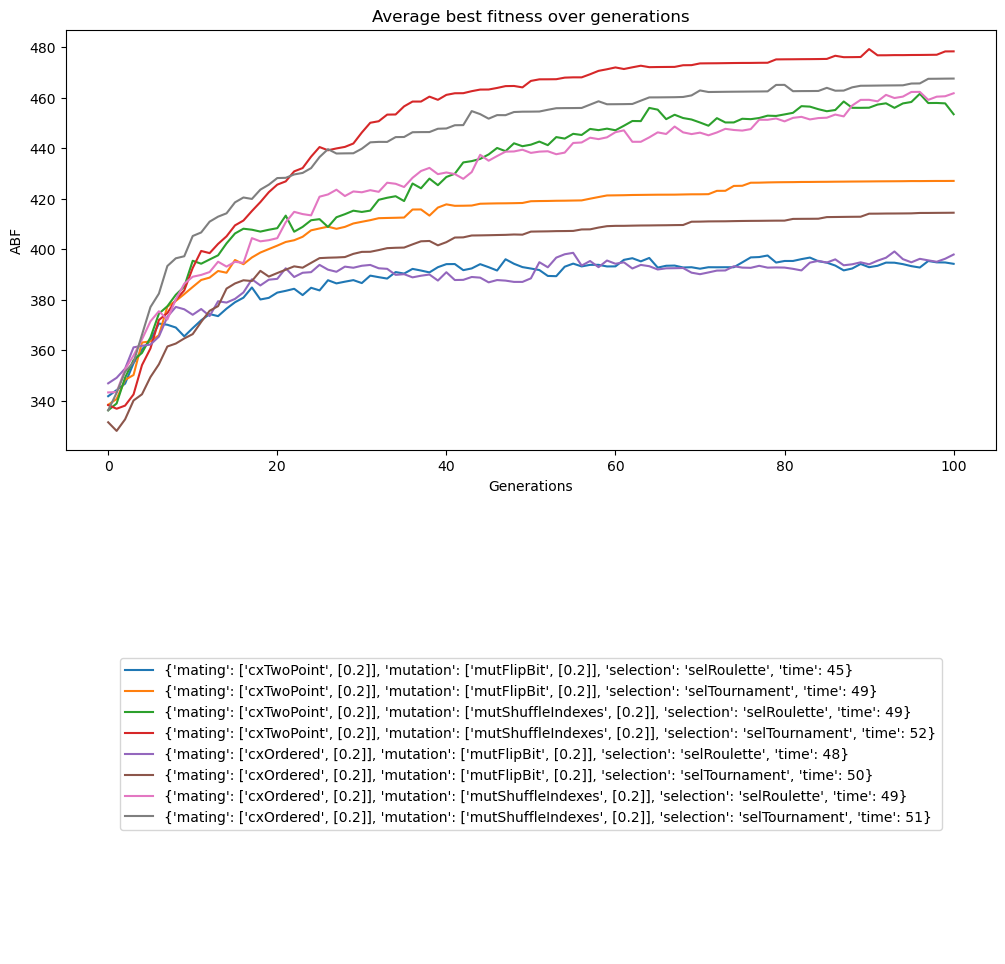

In [10]:
# Plot botht the figure and the legend separately
plt.figure()
fig, axes = plt.subplots(ncols=1,nrows=2,figsize=(12,12))
axes[0].plot(abf,label=config)
h,l = axes[0].get_legend_handles_labels()
axes[0].set_xlabel('Generations')
axes[0].set_ylabel('ABF')
axes[0].set_title('Average best fitness over generations')
axes[1].legend(h,l,loc='center')
axes[1].axis('off')

Text(0.5, 1.0, 'Boxplot of fitness of best indivuals for each configuration')

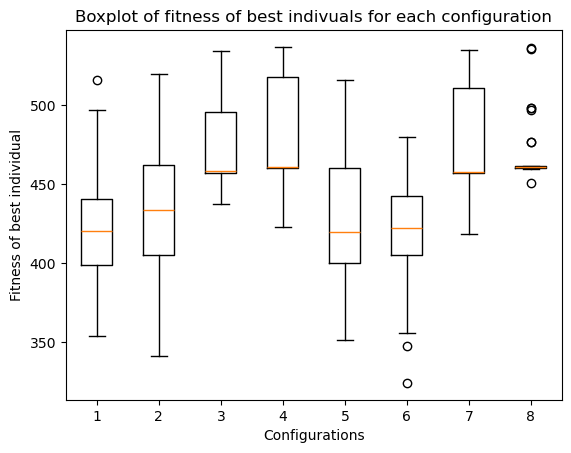

In [11]:
plt.boxplot(best_individuals);
plt.xlabel('Configurations')
plt.ylabel('Fitness of best individual')
plt.title('Boxplot of fitness of best indivuals for each configuration')

Function below is the decorator function for question 4, it seems like it should work but it returns individuals with 4 items in each column for some reason, not entirely sure why tbh because if you just input an individual it returns it properly, maybe some fresh eyes can fix it

In [12]:
def max_entries(max_nonzero):
    def decorator(func):
        def wrapper(*args,**kargs):
            offspring = func(*args,**kargs)
            for child in offspring:
                child = list_to_array(child)
                for column in range(child.shape[0]):
                    row = 0
                    while (sum(child[:,column]!=0)) > max_nonzero:
                        child[row,column] = 0
                        row+= 1
            return offspring
        return wrapper
    return decorator

        
max_nonzero = 2
toolbox.register('mate',tools.cxTwoPoint)
toolbox.register('mutate',tools.mutFlipBit, indpb = 0.05 )

toolbox.decorate("mate", max_entries(max_nonzero))
toolbox.decorate("mutate", max_entries(max_nonzero))
logbook, best_ind = main(ngen,mu,0.05,0.05)